In [2]:
import pandas as pd
import numpy as np
import os
import re

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from utils import feat_eng, models, process
from useful.eda import basic_info

##### Abstract

The data comes from the following link: https://www.kaggle.com/rmisra/news-category-dataset. 

Overall the dataset contains over 200K headlines from the Huffington Post between 2012 and 2018. The dataset has six columns that capture the category, headlines, author, link, description, and date the article was published. Overall there are 40 different categories ranging from politics to education. In general the top categories are politics, wellness, and entertainment. For the purposes of this notebook we won't be using the other columnns but it is worthy noting that each date may have more than one headline. More information about the data can be found below this abstract.

The goal of the notebook will be to take the headline column and use topic modeling to recreate the categories. Since we already have hand-labeled category information it will be interesting to see if our models match the ground truth data that we have. To accomplish this we will use non-negative matrix factorization (NMF) to 1) choose the optimal number of topics and 2) associate documents/terms with those topics. NMF is explained in further detail below, but basically it decomposes a document-term matrix into factors by which you can parse document/topics and document/terms from. 

##### Approach

The project will happen in multiple stages consisting of 1) preprocess the text, 2) create a document-term matrix using tf-idf 3) create the NMF model using the doc-term matrix  4) select the optimal number of topics using word2vec and calculate topic coherence 5) based on the optimal k topics print out top terms, documents and compare to original labels for accuracy.

references/inspiration:<br>
-Benedek Rozemberczaki's boosted factorization: https://github.com/benedekrozemberczki/BoostedFactorization <br>
-Derek Greene's excellent github & papers: https://github.com/derekgreene 

In [29]:
#load the data and look at the structure
data = pd.read_json('data/' + [x for x in os.listdir('data/') if x.endswith('.json')][0], lines=True)

basic_info.data_info(data,None)

basic info for this dataframe...


,category,headline,authors,link,short_description,date
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26


Index(['category', 'headline', 'authors', 'link', 'short_description'], dtype='object')
The number of non-numerical columns is 5
Index([], dtype='object')
The number of numerical columns is 0
missing data/column names....
                   0
date               0
short_description  0
link               0
authors            0
headline           0
category           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
category             200853 non-null object
headline             200853 non-null object
authors              200853 non-null object
link                 200853 non-null object
short_description    200853 non-null object
date                 200853 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB
None
        category        headline authors  \
count     200853          200853  200853   
unique        41          199344   27993   
top     POLITICS  Sunday Roundup           
freq     

##### Let's look at the distribution headlines by hand-labeled type

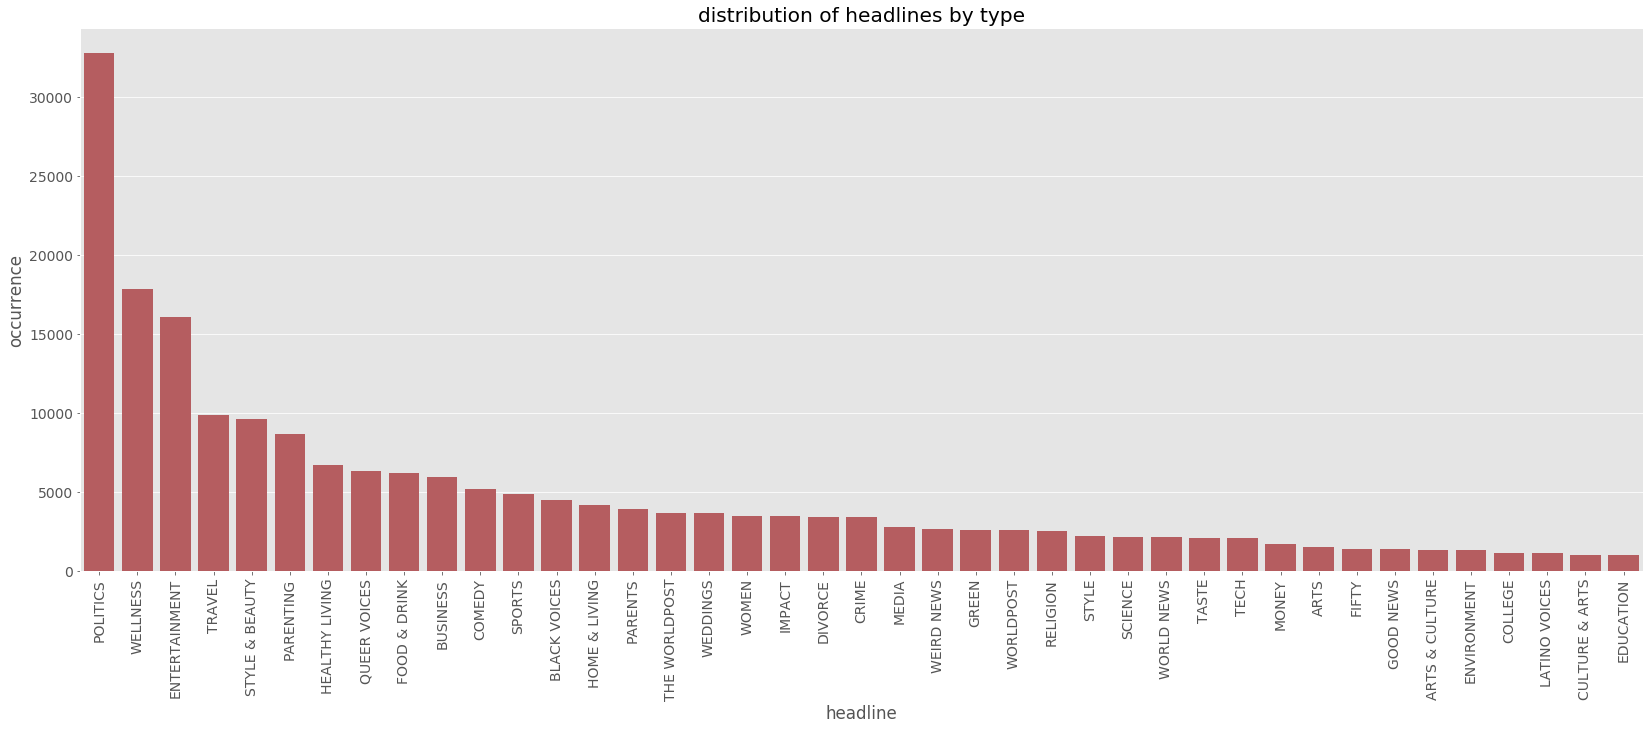

In [27]:
fig=plt.figure(figsize=(28,10))
sns.set_color_codes()


sns.barplot(data['category'].value_counts().index, 
            data['category'].value_counts().values,
            color='r'
        )

plt.title('distribution of headlines by type')
plt.xlabel('headline')
plt.ylabel('occurrence')
plt.xticks(rotation=90)
plt.show()

##### Create a document-term matrix with TF-IDF

Before we create our input/doc-term matrix for the NMF model we need to preprocess the data. The function preprocess (code is in the template_code folder in this project) removes stop-words, finds the stem, and lowercases words in the dataset.

TF-IDF gives more weight to important tokens in the text, and consists of two parts; term frequency (TF) and inverse document frequency (IDF). TF refers to the number of times a term appears in a single document whereas IDF refers to the total number of documents that contain that term. IDF seeks to penalizes terms that appear too commonly throughout all the documents. 

In the preprocessing code below I've set max_df in the tf_idf parameter to 0.95. This means ignore documents that appear in more than 95% of the documents. While I set min_df to 20, which means ignore terms that appear in less than 20 documents. This appeared to create the most accurate topic models as you will see below.

In [5]:
from sklearn.externals import joblib
import operator

tfidf = feat_eng.tfidf(0.95,20)
#file = [x for x in os.listdir('./data/') if x.endswith('headlines-tfidf.pkl')][0]

if os.path.exists('./data/headlines-tfidf.pkl') == False:
    print('processing data...')
    
    #default bigrams=False and stem=False
    df_ = tfidf.fit_transform(
                    process.preprocess(data['headline'], bigrams=False ,stem=True
                ).apply(lambda x: ', '.join(map(str, x))),
            )

    terms = tfidf.get_feature_names()
    value = df_.sum(axis=0)

    ranked_tokens = sorted({term: value[0,col] for col, term in enumerate(terms)}.items(), 
                           key=operator.itemgetter(1), 
                           reverse=True)

    #dump the results to a pickle file
    joblib.dump((df_,terms),'./data/headlines-tfidf.pkl')

else:
    print('file exists, loading pkl file...')
    (df_,terms) = joblib.load('./data/headlines-tfidf.pkl')
    
    value = df_.sum(axis=0)

    ranked_tokens = sorted({term: value[0,col] for col, term in enumerate(terms)}.items(), 
                           key=operator.itemgetter(1), 
                           reverse=True)

print('')
print(f'doc-term matrix dimensions are: {df_.shape[0]} x {df_.shape[1]}')
print('')
print(f'there are {len(terms)} unique terms in the corpus')
print('')
print('the top 20 TF-IDF terms are:')
print('='*50)

#print out top 20 tf-idf terms
for x,y,z in [(i+1,p[0],p[1]) for i,p in enumerate(ranked_tokens[0:20])]:
    print(x,y,z)
print('='*50)

file exists, loading pkl file...

doc-term matrix dimensions are: 200853 x 6609

there are 6609 unique terms in the corpus

the top 20 TF-IDF terms are:
1 trump 2762.1109368024345
2 photo 2683.6402965957504
3 new 2042.6430990020433
4 day 1568.1877551463085
5 video 1519.137516376305
6 make 1512.152354151106
7 get 1489.2475489853248
8 say 1412.1143828563352
9 year 1348.8330024427337
10 way 1303.6864887341233
11 donald 1256.760195314423
12 best 1213.1635222548537
13 love 1095.586862505542
14 world 1077.0971616338682
15 time 1050.535578631587
16 thing 1045.4585478835584
17 women 1040.0298284605306
18 kid 1033.971571974161
19 life 1023.3423099305435
20 one 993.1421722499074


##### Visualize the tfidf words using SVD

We decompose the corpus into two dimensions using SVD and we plot the results. The data are clustered around the vertex and from this method we can derive no significant meaning and/or clusters. Although the vertex is crowded, as we move away from the majority of the words we can start to see some related words. One thing that sticks out are political words that appear to be clustered.

In [6]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

Loading BokehJS ...

In [34]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_ = TfidfVectorizer(max_df=0.95,min_df=20,sublinear_tf=True)

graph_data = tfidf_.fit_transform(
                    process.preprocess(data['headline'], bigrams=False ,stem=True
                ).apply(lambda x: ', '.join(map(str, x))),
            )

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(graph_data.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], tfidf_.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="6pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=800, plot_height=800)
plot.circle("x", "y", size=8, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

### Create topic models

##### Matrix Factorization

The document-term matrix calculated with tf-idf can be decomposed into two smaller matrices W & H using a technique called Non-Negative Matrix Factorization. The W matrix dimensions are n x k which translates to documents x topics. The H matrix consists of the dimensions k x m which is equivalent to topics x terms. 

In our case we have 200k+ documents (headlines) and 66k+ terms. Because this is an unsupervised model we will look for the value of k (topics) with the highest mean coherence. Coherence can be otherwise stated as the terms that best represent the desired topic.

For example with k=4 (4 topics): <br>

W matrix dimensions will be: 220853 x 4 ( n x k --> headlines x topics ) <br>
H matrix dimensions will be: 4 x 6609 ( k x m --> topics x terms ) <br>

##### Parameters:

NMF will be initiated with singular value decomposition (SVD) with is equivalent to the paramenter 'nnsvd' in sklearn. NMF can be initiated randomly but it will reduce what is called 'stability' model. Meaning that the output of the model (topic coherence) is different each time. 

In [28]:
from sklearn.decomposition import NMF
import pickle

if os.path.exists('./data/nmf-output.pkl') == False:
    print('processing nmf...')
    kmin, kmax = 4,15
    
    print(f'calculating nmf for k {kmin} to {kmax}...')
    d = {}
    for k in range(kmin,kmax+1):
        model = NMF(init='nndsvd', n_components=k) 
        d[k] = model.fit_transform(df_), model.components_ #collect W & H factors
    
    print('dumping file to pkl...')
    output = open('./data/nmf-output.pkl', 'wb')
    pickle.dump(d, output)
    output.close()
    print('done')
    
else:
    print('file exists, loading data...')
    
    pkl_file = open('./data/nmf-output.pkl', 'rb')
    d = pickle.load(pkl_file)
    pkl_file.close()
    
    print('loaded...')

file exists, loading data...
loaded...


##### Construct the word embedding model using word2vec




As previously explained above, the NMF step breaks the model into two matrices H and W, and both of those matrices contain either documents x topics, or documents x terms. In order to see which model has the highest coherence we will run the data through a word2vec model so that we can compare each NMF model with a value of k to a coherence score. 

Word2Vec works by shifting values of word vectors close to eachother based on the context/proximity to eachother in a sentence. In this case below we used a skip-gram model as opposed to a contininous bag of words (CBOW). Skip-gram seeks to predict the words around a given word as opposed to the opposite approach in CBOW. A similarity score is determined using cosine similarity. Essentially, the smaller the angle between word vectors, the higher the cosine value and thus the more likely a word is to associated with another.

In [9]:
import gensim

if os.path.exists('./data/w2v-model.bin') == False:
    print('preprocessing text data for w2v model')
    w2v_raw = process.preprocess(data['headline'], bigrams=False ,stem=True)

    print('making w2v model')
    w2v_m = gensim.models.Word2Vec(w2v_raw, size=500, min_count=20, sg=1)

    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')
    w2v_m.save('./data/w2v-model.bin')
    
else:
    print('file exists...')
    w2v_m = gensim.models.Word2Vec.load('./data/w2v-model.bin')
    print(f'word2vec model has {len(w2v_m.wv.vocab)} terms')


file exists...
word2vec model has 6633 terms


##### Gather the coherence scores for each k 

Below for each topic in all the possible topic models we retrieve the top 10 terms and calculate a mean coherence score from each topic based on our word2vec values. We then graph that out to see which k value has the highest coherence value.

In [30]:
from utils.models import calculate_coherence, top_term

k_values, coherences = [],[]
for k in d.keys():
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = [top_term(terms, d[k][0], topic_index, 10) for topic_index in range(k)]

    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_m, term_rankings))    

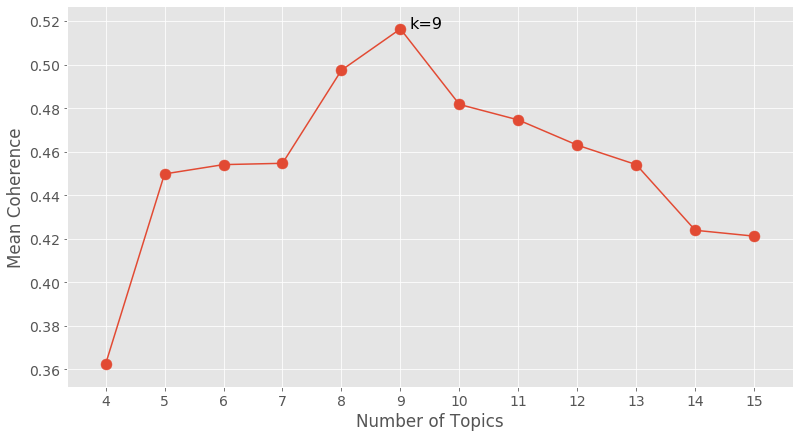

In [31]:
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot(k_values, coherences)
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

##### Top terms and headlines for our top k value

Finally for our best value of k we print out the 1) top terms 2) top headlines 3) ground truth labels for comparison

In [12]:
from utils.models import get_top_snippets

k = best_k
W = d[k][0]
H = d[k][1]
sentences = [headline[0:min(len(headline),100)] for headline in data['headline']]
descriptors = [top_term(terms, H, topic_index, 10) for topic_index in range(k)]


for i in range(k):
    topic = i
    headlines = 15

    d_ = {i+1: [data[data['headline']==sentences]['category'].values[0], sentences]
             for i,sentences in enumerate(get_top_snippets(sentences, W, topic, headlines))
        }

    temp_ = pd.DataFrame.from_dict(d_, orient='index').rename(columns={0:'ground_truth',1:'NMF categorized'})


    print('#''='*30)
    print(f'top terms for topic {topic}')
    print(descriptors[topic])

    print('='*50)
    gt_top = temp_['ground_truth'].value_counts().index[0]
    print(f'top ground truth label: {gt_top}')

    print('='*50)
    print(f'ground truth v. top headlines for topic {topic}')
    print(temp_)
    print('')

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
top terms for topic 0
['thing', 'know', 'need', 'video', 'say', 'kid', 'parent', 'life', 'one', 'women']
top ground truth label: PARENTING
ground truth v. top headlines for topic 0
      ground_truth                                    NMF categorized
1        PARENTING           3 Things Kids Need to Know About Yik Yak
2          DIVORCE  The One Thing a Divorced Parent Needs to Know ...
3          DIVORCE  10 Things All Divorcing Parents Should Say To ...
4        PARENTING  More Things You Should Know About A Special Ne...
5          PARENTS                       Kids Say the Darndest Things
6        PARENTING                10 Things Adoptees Want You to Know
7   HEALTHY LIVING               9 Things Pessimists Want You To Know
8   HEALTHY LIVING  5 Things Ayurveda Wants You to Know About Your...
9    ENTERTAINMENT   The One Thing You Need To Know About 'The Judge'
10       PARENTING  15 Things Never to Say to Parents of B

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
top terms for topic 6
['get', 'way', 'back', 'marri', 'divorc', 'help', 'sleep', 'tip', 'readi', 'rid']
top ground truth label: WELLNESS
ground truth v. top headlines for topic 6
      ground_truth                         NMF categorized
1     FOOD & DRINK       How to Get Clumps in Your Granola
2         WELLNESS                              Getting It
3        PARENTING                Getting Over Goldie Blox
4         WELLNESS              Why Are We Getting Fatter?
5         WELLNESS                    How Numb Can We Get?
6        PARENTING                   We Do Not Get Over It
7   HEALTHY LIVING                  Should You Get An IUD?
8   HEALTHY LIVING                     Get Out of Yourself
9   HEALTHY LIVING                 Getting a Ph.D. in You!
10           WOMEN                Don't Just 'Get Over It'
11          COMEDY   Why Are We Getting Fatter And Fatter?
12           STYLE              Why I Will Get  a Fa

##### Method #2: LDA

Please see the following link for the kaggle notebook with the LDA model that will be used for comparison. This model was trained on kaggle to utlitize the GPUs because LDA is computationally expensive to run on a local computer. After the 

In [49]:
vectorizer = CountVectorizer(min_df=20, max_df=0.95)

if os.path.exists('./data/headlines-bow.pkl') == False:
    print('processing data...')
    
    #default bigrams=False and stem=False
    dfbow_ = vectorizer.fit_transform(
                    process.preprocess(data['headline'], bigrams=False ,stem=True
                ).apply(lambda x: ', '.join(map(str, x))),
            )

    #dump the results to a pickle file
    joblib.dump((dfbow_),'./data/headlines-bow.pkl')
    print('done!')

else:
    print('file exists, loading pkl file...')
    (dfbow_) = joblib.load('./data/headlines-bow.pkl')

processing data...


In [50]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = best_k

data_vectorized = dfbow_
  
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)

joblib.dump((lda_Z), './data/lda_Z.pkl')

['./data/lda_Z.pkl']

In [51]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8      -72.616478  -96.547691       1        1  12.597354
1      123.556564 -282.237091       2        1  11.649994
3     -170.253998 -333.705872       3        1  11.560218
2      246.939865  -44.684155       4        1  11.359145
5     -342.509125  -89.613297       5        1  11.217899
6     -259.872711  165.230957       6        1  11.062986
7      -54.830997  360.169678       7        1  10.404777
4       14.950437  111.163116       8        1  10.284539
0      239.680740  238.642242       9        1   9.863088, topic_info=     Category          Freq    Term         Total  loglift  logprob
4398  Default  18139.000000   photo  18139.000000  30.0000  30.0000
6324  Default   8956.000000   video   8956.000000  29.0000  29.0000
541   Default   4854.000000    best   4854.000000  28.0000  28.0000
6572  Default   4625.000000    year   4625.000000  27.0000  27.0000
6420  Default   4294.000000     way   4294.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
6139   Topic9   3454.066429   trump   7149.636812   1.5889  -3.5265
4005   Topic9   3010.578553     new   8738.454094   1.2508  -3.6640
5856   Topic9   1412.857482    take   2793.527665   1.6347  -4.4205
4885   Topic9   1107.272544  report   2227.659307   1.6173  -4.6642
6523   Topic9    825.416965   women   3077.814391   1.0003  -4.9580

[353 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
50        7  0.998810    actual
96        7  0.999314       age
149       7  0.998855     alleg
185       8  0.999706   america
186       6  0.999719  american
...     ...       ...       ...
6557      9  0.998866     wrong
6572      1  0.999786      year
6582      6  0.998352      yoga
6585      9  0.999496      york
6587      7  0.998032     young

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 4, 3, 6, 7, 8, 5, 1])

In [52]:
pldavis_d = panel.to_dict

print('dumping file to pkl...')
output = open('./data/pldavis-output.pkl', 'wb')
pickle.dump(pldavis_d, output)
output.close()
print('done')

dumping file to pkl...
done


In [53]:
pyLDAvis.save_html(panel, 'lda.html')

##### Discussion

Our model found 9 topics to be optimal. Our original dataset contained 40 hand-labeled topics in total, but I felt it better to constrain the topics to a more sensiable amount. Also many of the hand-labelled topics seem to overlap and may have be specific to the huffington post. Since unsupervised learning is highly interpretable I felt that it was best to for me to compare the results for the top 15 documents/terms for each delievered topic. In reality this technique would be used without pre-labeled data, so I might choose a value from the list provide in the top terms. Immediately topic 1 which I have labelled as politics jumps out at me as being modeled the best. As you can see from the top terms and documents it did quite well at spotting political terms. Another topic model, topic 7 seems to deal with love, wedding etc.. There is some overlap with wellness because the word love goes with phrases such as 'love your body'. In any regard there are some interesting clusters that developed in this model. There were some duplications in the clustering such as wellness, food & drink, and parenting. If you look at the topics that the model outputted you can see that there may be a distinction between some of these overlaps though. 

##### Conclusion and future work

There are a number of steps to take from here. It would be interesting to see how this model would perform on a new un-labeled dataset from either another news headline dataset. Another interesting path would be to compare a probablistic model like LDA vs. this NMF model. Also it would be interesting to run the article text through this processor and compare it against the headline output. 